# Patristic Text Archive – work with the texts
Python 3.7 min required

In [1]:
import os,sys,glob,re
import json
from cltk.corpus.utils.importer import CorpusImporter
from cltk.corpus.multilingual import corpora as cp
from cltk.corpus.utils.formatter import cltk_normalize
from cltk.utils.frequency import Frequency
from cltk.text_reuse.levenshtein import Levenshtein
from MyCapytain.resources.texts.local.capitains.cts import CapitainsCtsText
from MyCapytain.common.constants import Mimetypes, XPATH_NAMESPACES
from lxml.etree import tostring
#import xml.etree.ElementTree as ET
from lxml import etree as ET
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer # tokenize
from difflib import SequenceMatcher
from collatex import *
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import folium
from folium.plugins import MarkerCluster

## Import the Patristic Text Archive in CLTK

In [ ]:
# Import Greek corpora
corpus_importer = CorpusImporter('greek') 
corpus_importer.import_corpus('greek_models_cltk')
corpus_importer.import_corpus('greek_lexica_perseus')

In [ ]:
# Import PTA as Corpus
MULTILINGUAL_CORPORA = cp.MULTILINGUAL_CORPORA + [
    {'encoding': 'utf-8',
     'markup': ['xml'],
     'location': 'local',
     'type': 'text',
     'name': 'patristic_text_archive'},
]
corpus_importer = CorpusImporter('multilingual') 
#corpus_importer.import_corpus('patristic_text_archive', '~/Dokumente/projekte/PatristicTextArchive/Pre-critical_editions')

## Normalize XML-Files

In [ ]:
def normalize_tei_xml():
    xml_dir = os.path.expanduser('~/Dokumente/projekte/PatristicTextArchive/Pre-critical_editions/data/*/*/*.xml')
    xml_paths = glob.glob(xml_dir)
    # new dir
    new_dir = os.path.expanduser('~/cltk_data/multilingual/text/patristic_text_archive_xml_normalized/')
    if not os.path.isdir(new_dir):
        os.makedirs(new_dir)
    for xml_path in xml_paths:
        _, xml_name = os.path.split(xml_path)
        with open(xml_path) as file_open:    
            text = file_open.read()
            normalized_text = cltk_normalize(text)
        new_plaintext_path = os.path.join(new_dir, xml_name)
        with open(new_plaintext_path, 'w') as file_open:
            file_open.write(normalized_text)
normalize_tei_xml()

## Convert TEI-XML to plaintext

In [ ]:
def tei_xml_to_text_capitains():
    """Use MyCapitains program to convert TEI to plaintext."""
    xml_dir = os.path.expanduser('~/Dokumente/projekte/PatristicTextArchive/Pre-critical_editions/data/pta0001/*/*.xml')
    xml_paths = glob.glob(xml_dir)
    xml_paths = [path for path in xml_paths if '__cts__' not in path]

    # new dir
    new_dir = os.path.expanduser('~/cltk_data/multilingual/text/patristic_text_archive_plaintext/')
    if not os.path.isdir(new_dir):
        os.makedirs(new_dir)
    
    for xml_path in xml_paths:
        _, xml_name = os.path.split(xml_path)
        xml_name = xml_name.rstrip('.xml')
        xml_name += '.txt'

        plain_text = ''
        with open(xml_path) as file_open:
            text = CapitainsCtsText(resource=file_open)
            for ref in text.getReffs(level=len(text.citation)):
                psg = text.getTextualNode(subreference=ref, simple=True)
                psg.plaintext_string_join = "" 
                text_line = psg.export(Mimetypes.PLAINTEXT, exclude=["tei:note","tei:rdg"])
                plain_text += text_line

        new_plaintext_path = os.path.join(new_dir, xml_name)
        with open(new_plaintext_path, 'w') as file_open:
            file_open.write(plain_text)

tei_xml_to_text_capitains()

Exportierte Plaintext-Dateien können mit Voyant-Tools z.B. weiterverarbeitet werden.

## Wordcount on all files in PTA

In [ ]:
word_breaks = RegexpTokenizer(r'\w+') # tokenize by whitespace
inputdir = "/home/stockhausen/cltk_data/multilingual/text/patristic_text_archive_plaintext" 
outputdir = "/home/stockhausen/cltk_data/user_data"
daten = {} # put wordcount in dictionary
wc = []
for file in os.listdir(inputdir):
    if file.endswith('.txt'):
        source = os.path.join(inputdir, file)
        content = open(source).read().lower()
        tokens = word_breaks.tokenize(content)
        wordcount = len(tokens)
        wc.append(wordcount)
        daten[file] = wordcount    
# Print accumulated wordcount
print("Number of words in archive: "+str(sum(wc)))
# Write Wordcount in json file
with open('/home/stockhausen/cltk_data/user_data/patristic_text_archive-wordcount.json', 'w') as f:
    json.dump(daten, f, sort_keys=True)

## Word lists of all files (with frequency)

In [ ]:
freq = Frequency()
frequenz = {}
for file in os.listdir(inputdir):
    source = os.path.join(inputdir, file)
    content = open(source).read().lower()
    frequenz = freq.counter_from_str(" ".join(word_breaks.tokenize(content))) # tokenize content and then freq
    file_name = file.rstrip('.txt')
    file_name += '_words.json'
    # Write Wordcount in json file
    with open(os.path.join(outputdir, file_name), 'w') as f:
        json.dump(frequenz, f, ensure_ascii=False, sort_keys=True) # sortiert auch die Worte!

## Working with the encoded biblical references 

### Extract biblical quotations from tei-xml file

In [2]:
id = "pta009"
file_name = "pta0001."+id+".pta-grc1.xml"
path = os.path.expanduser('/home/stockhausen/Dokumente/projekte/PatristicTextArchive/Pre-critical_editions/data/pta0001/'+id)
source = os.path.join(path, file_name)
tree = ET.parse(source)
root = tree.getroot()
ns = {'tei': 'http://www.tei-c.org/ns/1.0'}
# title of text
title = root.find('.//tei:title', ns)
quotes = []
# only real quotes (not ref in seg type=allusion)
# case 1: ref in quote
for quote in root.findall('.//tei:p/tei:quote', ns):
    r_q = {}
    ref = quote.find('tei:ref', ns).attrib["cRef"]
    quotation = quote.text
    r_q[ref] = quotation
    quotes.append(r_q)
# case 2: ref in cit
for quote in root.findall('.//tei:cit', ns):
    r_q = {}
    ref = quote.find('tei:ref', ns).attrib["cRef"]
    quotation = quote.find('tei:quote', ns).text
    r_q[ref] = quotation
    quotes.append(r_q)
print(quotes)
# TODO: Noch nicht zu Ende

[{'LXX:Ps:118:12': 'Εὐλογητὸς εἶ, κύριε· δίδαξόν με τὰ δικαιώματά σου.'}, {'GNT:Mt:21:23': 'Προσῆλθον '}, {'LXX:Si:10:9': 'τί ἀλαζονεύει γῆ καὶ σποδὸς.'}, {'GNT:Mt:21:23': 'Ἐν ποίᾳ ἐξουσίᾳ ταῦτα ποιεῖς;'}, {'GNT:Mt:21:23': 'Ἐν ποίᾳ ἐξουσίᾳ ταῦτα ποιεῖς;'}, {'GNT:1 Co:3:19': 'τὸν δρασσόμενον τοὺς σοφοὺς ἐν τῇ πανουργίᾳ αὐτῶν'}, {'GNT:Mt:21:23': 'Ἐν ποίᾳ ἐξουσίᾳ ταῦτα ποιεῖς;'}, {'GNT:Jn:10:24': 'Ἕως πότε τὴν ψυχὴν ἡμῶν αἴρεις; Εἰ σὺ εἶ ὁ Χριστός, εἰπὲ ἡμῖν παρρησίᾳ.'}, {'GNT:Jn:9:27': 'Εἶπον ὑμῖν καὶ οὐκ ἠκούσατε· τί πάλιν θέλετε ἀκούειν;'}, {'GNT:Jn:10:25': 'Τὰ ἔργα, ἃ ἐγὼ ποιῶ, ταῦτα μαρτυρεῖ περὶ ἐμοῦ.'}, {'GNT:Jn:10:24': 'Εἰ σὺ εἶ ὁ Χριστός, εἰπὲ ἡμῖν παρρησίᾳ· ἕως πότε τὴν ψυχὴν ἡμῶν αἴρεις;'}, {'GNT:Mt:26:63': 'Ὁρκίζω σε κατὰ τοῦ θεοῦ τοῦ ζῶντος, εἰπὲ ἡμῖν, εἰ σὺ εἶ ὁ υἱὸς τοῦ εὐλογητοῦ.'}, {'GNT:Mt:26:63': 'Εἰπέ '}, {'GNT:Mt:26:64': 'Σὺ εἴπας.'}, {'LXX:Wis:1:3': 'Σκολιοὶ γὰρ λογισμοὶ χωρίζουσιν ἀπὸ θεοῦ.'}, {'LXX:Wis:1:4': 'Εἰς κακότεχνον γὰρ ψυχὴν οὐκ εἰσελεύσεται σοφία.'}, {'GN

### Test accuracy (differences) of quotations 

In [3]:
# Texts
# Mt 22,42
a='Τίνα λέγετε εἶναι τὸν Χριστόν; τίνος ἐστὶν ὁ υἱός; Λέγουσιν οἱ γραμματεῖς καὶ οἱ φαρισαῖοι· Τοῦ Δαυίδ.'
b='λέγων· τί ὑμῖν δοκεῖ περὶ τοῦ χριστοῦ; τίνος υἱός ἐστιν; λέγουσιν αὐτῷ· τοῦ Δαυίδ.'
from cltk.corpus.utils.formatter import cltk_normalize
a = cltk_normalize(a.lower())
b = cltk_normalize(b.lower())

In [4]:
# using difflib
word_breaks = RegexpTokenizer(r'\w+') # whitespace

x = word_breaks.tokenize(a)
y = word_breaks.tokenize(b)

for tag, i, j, k, l in SequenceMatcher(None, x, y).get_opcodes():
  if tag == 'equal': print('Words in common:  ', " ".join(x[i:j]))
  if tag in ('delete', 'replace'): print('  Citation only:  ', " ".join(x[i:j]))
  if tag in ('insert', 'replace'): print('  Cited text only:', " ".join(y[k:l]))

  Citation only:   τίνα λέγετε εἶναι τὸν χριστόν
  Cited text only: λέγων τί ὑμῖν δοκεῖ περὶ τοῦ χριστοῦ
Words in common:   τίνος
  Citation only:   ἐστὶν ὁ
Words in common:   υἱός
  Cited text only: ἐστιν
Words in common:   λέγουσιν
  Citation only:   οἱ γραμματεῖς καὶ οἱ φαρισαῖοι
  Cited text only: αὐτῷ
Words in common:   τοῦ δαυίδ


In [5]:
### Use CollateX for text reuse detection
collation = Collation()
collation.add_plain_witness("Sev", a)
collation.add_plain_witness("Bib", b)
alignment_table = collate(collation, segmentation=False, near_match=True)
print(alignment_table)

+-----+-------+---+--------+-------+-------+------+-----+---------+---+-------+-------+---+------+-------+---+----------+----+------------+-----+----+-----------+---+-----+-------+---+
| Sev | τίνα  | - | λέγετε | εἶναι | -     | -    | τὸν | χριστόν | ; | τίνος | ἐστὶν | ὁ | υἱός | -     | ; | λέγουσιν | οἱ | γραμματεῖς | καὶ | οἱ | φαρισαῖοι | · | τοῦ | δαυίδ | . |
| Bib | λέγων | · | τί     | ὑμῖν  | δοκεῖ | περὶ | τοῦ | χριστοῦ | ; | τίνος | -     | - | υἱός | ἐστιν | ; | λέγουσιν | -  | αὐτῷ       | -   | -  | -         | · | τοῦ | δαυίδ | . |
+-----+-------+---+--------+-------+-------+------+-----+---------+---+-------+-------+---+------+-------+---+----------+----+------------+-----+----+-----------+---+-----+-------+---+


In [6]:
# Levenshtein Distance
l = Levenshtein()
l.ratio("Ἰδοὺ ἀναβαίνομεν εἰς Ἱεροσόλυμα καὶ ὁ υἱὸς τοῦ ἀνθρώπου παραδίδοται εἰς χεῖρας", "ἰδοὺ ἀναβαίνομεν εἰς Ἱεροσόλυμα, καὶ ὁ υἱὸς τοῦ ἀνθρώπου παραδοθήσεται τοῖς ἀρχιερεῦσιν καὶ γραμματεῦσιν, καὶ κατακρινοῦσιν αὐτὸν θανάτῳ")

0.64

#### Show introducing text in "cit"-encoded quotes

In [7]:
for quote in root.findall('.//tei:cit', ns):
    quotation = quote.find('tei:ref', ns).text
    ref = quote.find('tei:ref', ns).attrib["cRef"]
    quote = quote.find('tei:quote', ns).text
    print(ref+": "+quotation+" ("+quote+")")

LXX:Lv:26:23-24: Ἄκουε αὐτοῦ λέγοντος διὰ Μωϋσέως·  (Ἐὰν ὑμεῖς πορεύησθε πρός με ὀρθοί, κἀγὼ πρὸς ὑμᾶς ὀρθός. Ἐὰν δὲ ὑμεῖς πλάγιοι, κἀγὼ χρήσομαι ὑμῖν θυμῷ πλαγίῳ.)
GNT:He:11:6: Τοῦ γὰρ ἀποστόλου οὐδένα εὑρίσκω μείζονα διδάσκαλον, δυνάμενόν μοι κρείττονα τὴν εὐσέβειαν ὑποτίθεσθαι· ὃς λαμπρᾷ χρησάμενος τῇ φωνῇ ὧδέ πη διδάσκει λέγων·  (Πιστεῦσαι γὰρ δεῖ τὸν προσερχόμενον θεῷ, ὅτι ἐστιν.)
LXX:Ps:32:4: Καὶ ὁ μακάριος Δαυὶδ ἐμελῴδησεν ὧδέ πη λέγων·  (Ὅτι εὐθὺς ὁ λόγος τοῦ κυρίου καὶ πάντα τὰ ἔργα αὐτοῦ ἐν πίστει.)
GNT:Rm:11:33-35: ὧδέ πη λέγων·  (Ὦ βάθος πλούτου σοφίας καὶ γνώσεως θεοῦ. Ὡς ἀνεξερεύνητα τὰ κρίματα αὐτοῦ καὶ ἀνεξιχνίαστοι αἱ ὁδοὶ αὐτοῦ. Τίς γὰρ ἔγνω νοῦν κυρίου; ἢ τίς σύμβουλος αὐτοῦ ἐγένετο; ἢ τίς προέδωκεν αὐτῷ, καὶ ἀνταποδοθήσεται αὐτῷ;)
LXX:Jr:2:12: διὰ τοῦ θαυμασίου Ἱερεμίου τὸ θεῖον ἐκεῖνο λόγιον·  (Ἔφριξεν οὐρανὸς ἐπὶ τοῦτο.)
LXX:Ps:105:32: Διὰ τοῦτο ὁ Δαυὶδ ἀπολογεῖται ὑπὲρ Μωϋσέως, προφήτης ὑπὲρ προφήτου·  (Καὶ παρώργισαν αὐτὸν ἐφ’ ὕδατος ἀντιλογίας, καὶ ἐκακώθη Μωϋσ

### Exctract biblical *reference* from tei-xml file

In [8]:
id = "pta009"
file_name = "pta0001."+id+".pta-grc1.xml"
path = os.path.expanduser('/home/stockhausen/Dokumente/projekte/PatristicTextArchive/Pre-critical_editions/data/pta0001/'+id)
source = os.path.join(path, file_name)
tree = ET.parse(source)
root = tree.getroot()
ns = {'tei': 'http://www.tei-c.org/ns/1.0'}
# title of text
title = root.find('.//tei:title', ns)
quotes = []
# only real quotes (not ref in seg type=allusion)
# case 1: ref in quote
for quote in root.findall('.//tei:quote/tei:ref', ns):
    ref = quote.attrib["cRef"]
    quotes.append(ref)
# case 2: ref in cit
for quote in root.findall('.//tei:cit/tei:ref', ns):
    ref = quote.attrib["cRef"]
    quotes.append(ref)
print("Datei "+file_name+" ("+title.text+") enthält "+str(len(quotes))+" biblische Zitate.")

Datei pta0001.pta009.pta-grc1.xml (Digital text of Severianus Gabalensis, In illud: In qua potestate haec facis) enthält 150 biblische Zitate.


### Extract all AT quotes

In [9]:
AT = [s for s in quotes if "LXX" in s]
regex=re.compile("LXX:([0-9A-Za-z ]*:.*)")
AT = [a.group(1) for b in AT for a in [regex.search(b)] if a]
print("Anzahl der AT-Zitate: "+(str(len(AT))))
## extract from this list only book names and write to new list
regex=re.compile("([0-9A-Za-z ]*):.*")
AT_books = [a.group(1) for b in AT for a in [regex.search(b)] if a]
## extract from this list only book names and chapters and write to new list
regex=re.compile("([0-9A-Za-z ]*?:[0-9]+?):.*")
AT_bkch = [a.group(1) for b in AT for a in [regex.search(b)] if a]

Anzahl der AT-Zitate: 78


### Extract all NT quotes    

In [10]:
NT = [s for s in quotes if "GNT" in s]
regex=re.compile("GNT:([0-9A-Za-z ]*:.*)")
NT = [a.group(1) for b in NT for a in [regex.search(b)] if a]
print("Anzahl der NT-Zitate: "+(str(len(NT))))
## extract from this list only book names and write to new list
regex=re.compile("([0-9A-Za-z ]*):.*")
NT_books = [a.group(1) for b in NT for a in [regex.search(b)] if a]
## extract from this list only book names and chapters and write to new list
regex=re.compile("([0-9A-Za-z ]*?:[0-9]+?):.*")
NT_bkch = [a.group(1) for b in NT for a in [regex.search(b)] if a]

Anzahl der NT-Zitate: 72


### Ratio of AT/NT-quotes of all quotations

In [11]:
anteil_nt = '{:.0%}'.format(len(NT)/len(quotes))
print("Anteil der NT-Zitate an allen Zitaten: "+str(anteil_nt))
anteil_at = '{:.0%}'.format(len(AT)/len(quotes))
print("Anteil der AT-Zitate an allen Zitaten: "+str(anteil_at))
# Remove duplicates from list and count instances of quotes
# AT
at = {x:AT.count(x) for x in sorted(AT, reverse=True)} # all single quotes
at_books = {x:AT_books.count(x) for x in AT_books} # all quotes (book)
at_bkch = {x:AT_bkch.count(x) for x in sorted(AT_bkch, reverse=True)} # all books with chapter
# NT
nt = {x:NT.count(x) for x in sorted(NT, reverse=True)} # all single quotes
nt_books = {x:NT_books.count(x) for x in NT_books} # all quotes (book)
nt_bkch = {x:NT_bkch.count(x) for x in sorted(NT_bkch, reverse=True)} # all books with chapter

Anteil der NT-Zitate an allen Zitaten: 48%
Anteil der AT-Zitate an allen Zitaten: 52%


## Plot AT quotations (books)

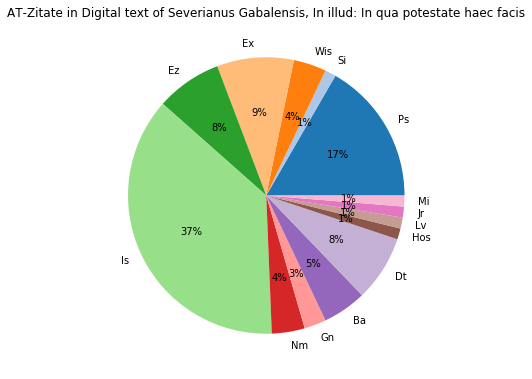

In [12]:
fig = plt.figure(1, figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.title('AT-Zitate in '+title.text)

colors = list(plt.cm.tab20(np.arange(20)))
labels = list(at_books.keys())
values = list(at_books.values())

patches, texts, autotexts = ax.pie(values, labels=labels, colors=colors, autopct='%.0f%%')

proptease = fm.FontProperties()
proptease.set_size('medium')
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)

plt.show()

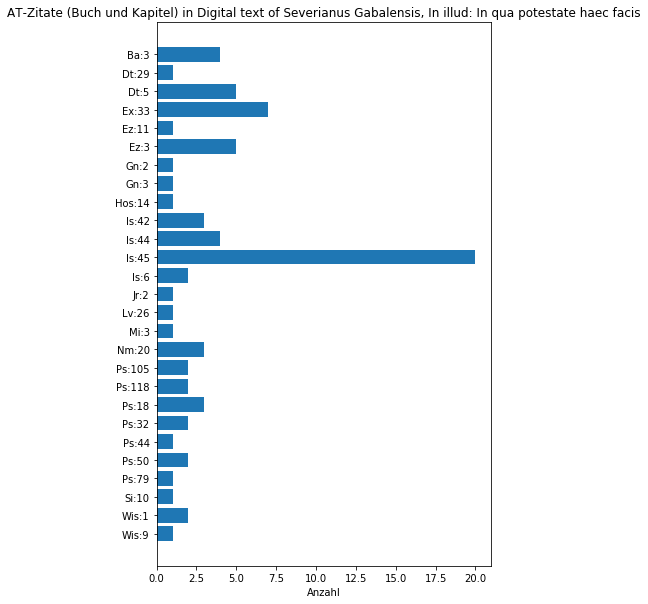

In [13]:
# AT-Zitate (Buch Kapitel) und mit absoluten Zahlen
fig = plt.figure(figsize=(6,10))
objects = list(at_bkch.keys())
y_pos = np.arange(len(objects))
performance = list(at_bkch.values())
 
plt.barh(y_pos, performance, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Anzahl')
plt.title('AT-Zitate (Buch und Kapitel) in '+title.text)

plt.show()
# Biblical books are sorted reversed alphabetical

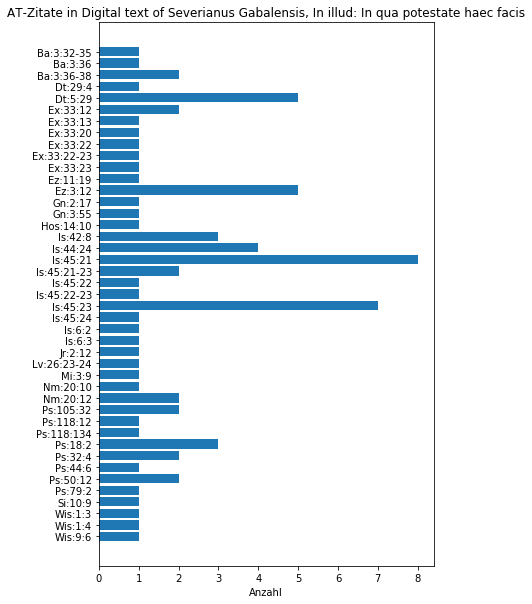

In [14]:
# AT-Zitate im einzelnen und mit absoluten Zahlen
fig = plt.figure(figsize=(6,10))
objects = list(at.keys())
y_pos = np.arange(len(objects))
performance = list(at.values())
 
plt.barh(y_pos, performance, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Anzahl')
plt.title('AT-Zitate in '+title.text)

plt.show()
# Biblical books are sorted reversed alphabetical

## Plot NT-Quotations

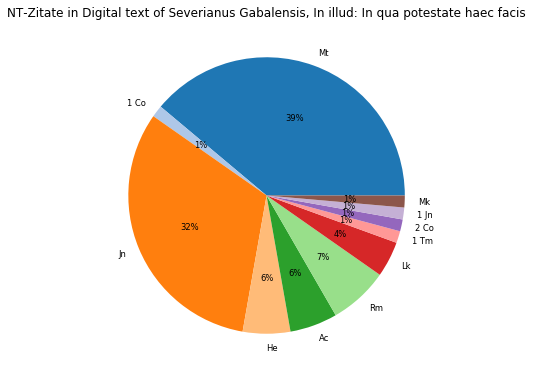

In [15]:
fig = plt.figure(1, figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.title('NT-Zitate in '+title.text)

colors = list(plt.cm.tab20(np.arange(20)))
labels = list(nt_books.keys())
values = list(nt_books.values())

patches, texts, autotexts = ax.pie(values, labels=labels, colors=colors, autopct='%.0f%%')

proptease = fm.FontProperties()
proptease.set_size('small')
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)

plt.show()

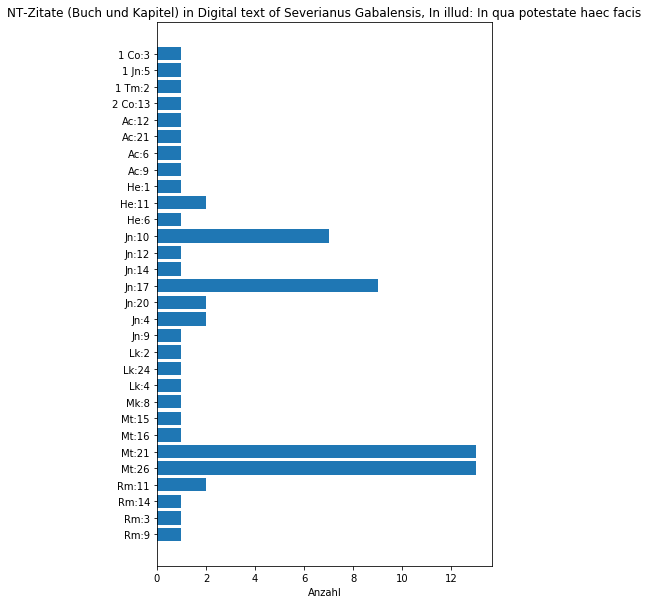

In [16]:
# NT-Zitate (Buch Kapitel) und mit absoluten Zahlen
fig = plt.figure(figsize=(6,10))
objects = list(nt_bkch.keys())
y_pos = np.arange(len(objects))
performance = list(nt_bkch.values())
 
plt.barh(y_pos, performance, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Anzahl')
plt.title('NT-Zitate (Buch und Kapitel) in '+title.text)

plt.show()
# Biblical books are sorted reversed alphabetical

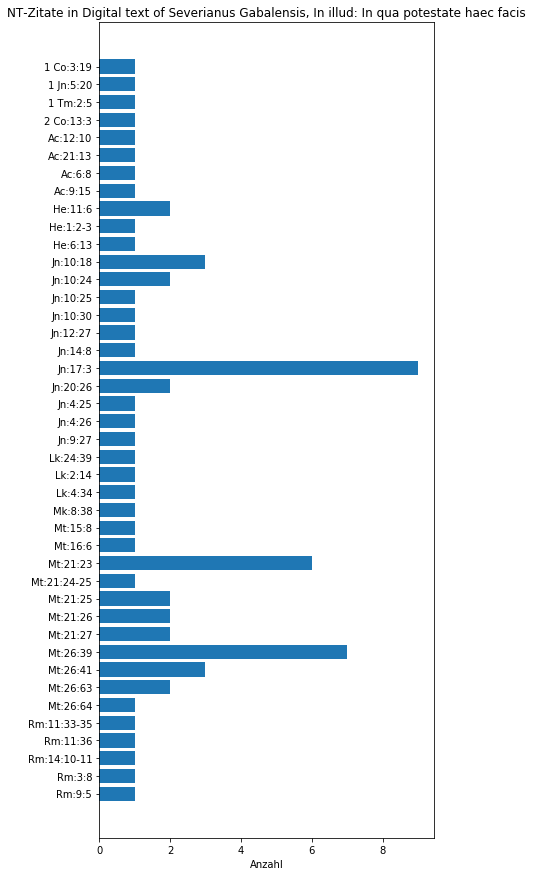

In [17]:
fig = plt.figure(figsize=(6,15))    
objects = list(nt.keys())
y_pos = np.arange(len(objects))
performance = list(nt.values())
 
plt.barh(y_pos, performance, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Anzahl')
plt.title('NT-Zitate in '+title.text)

plt.show()

## Map data

### Exctract places from file

In [18]:
file_name = "pta0022.pta010.pta-grc1.xml"
path = os.path.expanduser('/home/stockhausen/Dokumente/projekte/PatristicTextArchive/Pre-critical_editions/data/pta0022/pta010')
source = os.path.join(path, file_name)
with open(source) as file_open:
    soup = BeautifulSoup(file_open, 'lxml')
    strip_tags = ['cit', 'ref', 'quote', 'said', 'gap'] # remove not needed tags to avoid problems
    for tag in strip_tags: 
        for match in soup.find_all(tag):
            match.replaceWithChildren()
    body = soup.find("text")
    title = soup.find('title')
    places = []
    for place in body.find_all('placename'):
        place_entry = {}
        refs = place["ref"]
        place_name = place.text
        p = place.parent
        div = p.parent
        chapter = div["n"] 
        ct_before = place.previous_siblings
        context_before_list = []
        for context_b in ct_before:
            context_before_list.append(context_b.string)
        context_before = " ".join(context_before_list[::-1]).split()[-5:]
        ct_after = place.next_siblings
        context_after_list = []
        for context_a in ct_after:
            context_after_list.append(context_a.string)
        context_after = " ".join(context_after_list).split()[:5]
        context = chapter+" "+" ".join(context_before)+" <b>"+place_name+"</b> "+" ".join(context_after)
        if not any(d['ID'] == refs for d in places):
            place_entry["ID"] = refs
            place_entry["Context"] = context
            place_entry["Count"] = 1
            places.append(place_entry)
        else:
            matches = next(d for d in places if refs == d["ID"])
            tc = matches["Count"]
            myid = matches["ID"]
            mycontext = matches["Context"]
            place_entry["ID"] = myid
            place_entry["Context"] = mycontext+"<br/>"+context
            place_entry["Count"] = tc+1
            places.remove(matches)
            places.append(place_entry)
places_count = [d['Count'] for d in places]
places_count = sum(places_count)
print("Datei "+file_name+" ("+title.text+") enthält "+str(places_count)+" Ortsnennungen und "+str(len(places))+" Orte.")
print(places)

Datei pta0022.pta010.pta-grc1.xml (Apologia ad Constantium) enthält 59 Ortsnennungen und 27 Orte.
[{'ID': 'http://pleiades.stoa.org/places/197446', 'Context': '3 περὶ Θάλασσον ἦλθον εἰς τὴν <b>Πιτυβίωνα</b> καὶ ἡμεῖς ἐν τῇ Ἀκυληίᾳ', 'Count': 1}, {'ID': 'http://pleiades.stoa.org/places/393473', 'Context': '3 εἰπεῖν καὶ Κρισπῖνος ὁ τῆς <b>Πατάβων</b> καὶ Λούκιλλος ὁ ἐν Βερωνὶ', 'Count': 1}, {'ID': 'http://pleiades.stoa.org/places/383816', 'Context': '3 Πατάβων καὶ Λούκιλλος ὁ ἐν <b>Βερωνὶ</b> καὶ Διονύσιος ὁ ἐν Ἤλιδι', 'Count': 1}, {'ID': 'http://pleiades.stoa.org/places/570220', 'Context': '3 Βερωνὶ καὶ Διονύσιος ὁ ἐν <b>Ἤλιδι</b> καὶ Βικέντιος ὁ ἐν Καμπανίᾳ', 'Count': 1}, {'ID': 'http://pleiades.stoa.org/places/383706', 'Context': '3 Τριβέρεως καὶ Προτάσιος ὁ τῆς <b>Μεδιολάνου</b> , δύναται καὶ Εὐγένιος ὁ<br/>4 αὐτόν· ἦν δὲ ἐν τῇ <b>Μεδιολάνῳ</b> . ἐγὼ δὲ διερωτῶν τὴν<br/>4 ψεύδομαι. κατελθὼν τοίνυν εἰς τὴν <b>Μεδιόλανον</b> εἶδον πολλὴν φιλανθρωπίαν· κατηξίωσε γὰρ', 'Count': 3}, {'ID'

### Show on map

In [19]:
# Pleiades data from https://github.com/pelagios/recogito2-places-pleiades -> pleiades-20170403.jsonl
contents = open('pleiades-20170403.jsonl', "r").read() 
data = [json.loads(str(item)) for item in contents.strip().split('\n')]

In [20]:
# base map
m = folium.Map(location=[40.4285312, 29.715356500000002],
               zoom_start=4,
              tiles = 'http://pelagios.org/tilesets/imperium/{z}/{x}/{y}.png',
              attr = '<a href="http://dare.ht.lu.se">DARE 2015</a> (CC-BY-SA)',
              control_scale=True)

In [21]:
map_data = []
for place in range(len(places)):
    entries = []
    for key in places[place]:
        entries.append(places[place][key])
    entries = (entries)
    map_data.append(entries)
for place in map_data:
    location = next(item for item in data if item["uri"] == place[0])
    lc = location.get("reprPoint")
    lat = lc[1]
    long = lc[0]
    place_name = location.get("title")
    popup_entry = place[1]
    mult = place[2]
    # Add marker to map
    folium.CircleMarker(
    radius=2*mult,
    location=[lat,long],
    tooltip=place_name,
    popup=popup_entry,
    color='crimson',
    fill=True,
    ).add_to(m)
    #folium.Marker([lat,long]).add_to(m)

In [22]:
# show map
print("Places mentioned in "+file_name)
m
#m.save('ApolConst-map.html')

Places mentioned in pta0022.pta010.pta-grc1.xml
